# Algorithmic Trading with Predictors

Using the example of crypto pricing from yfinance, we can extract 5-min interval data for, say Ethereum-USD, over a 60 day period. And can similarly overlap with other crypto pairs. The pricing data consists of open, close, high, low and technical-based predicators can be built on that.

The predictor variables are features that might be related to market behavior. These data can be the technical indicators, the market data, the sentiment data, breadth data, fundamental data, government data, etc. 

On the technicals, we can consider simply the close-open delta to determine whether the price has increased or decreased. With the price, % changes, etc. as the features and the target predictor (i.e. whether close is higher than open) as a label, we can train a machine learning model to attempt to forecast this.

In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 13.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from yfinance import Ticker
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np

We use yfinance to download the data, pandas for data processing, and sklearn to split the data for training and testing. The split will be an important step here because we need to make sure everything still works out of the sample. XGBoost has been used due to its stellar out-of-box performance and no requirement for feature scaling.

In [ ]:
def get_ohlc(ticker, period='60d', interval='5m'):
  cols = ['Open','High','Low','Close']
  ohlc = Ticker(ticker).history(period=period, interval=interval)[cols][:-1]
  return ohlc

df = get_ohlc('ETH-USD')

This function downloads open, high, low, and close prices for any given cryptocurrency pair and timeframe. There are limits, for example, only 60 days are available for the 5-minute interval. That gives us roughly 17,000 rows which is still a decent sample size for quick testing.

In [ ]:
df

,Open,High,Low,Close
Datetime,,,,
2022-01-14 00:00:00+00:00,3248.648682,3249.024658,3241.633789,3241.633789
2022-01-14 00:05:00+00:00,3239.208984,3239.208984,3236.229736,3237.604980
2022-01-14 00:10:00+00:00,3241.441406,3245.723633,3241.441406,3244.570801
2022-01-14 00:15:00+00:00,3251.201660,3253.119629,3251.201660,3253.119629
2022-01-14 00:20:00+00:00,3253.609619,3253.875488,3251.122070,3251.122070
...,...,...,...,...
2022-03-14 12:10:00+00:00,2582.415283,2582.415283,2577.841797,2577.841797
2022-03-14 12:15:00+00:00,2576.875488,2576.961914,2576.096680,2576.617432
2022-03-14 12:20:00+00:00,2576.008545,2576.182861,2575.731445,2575.919434


One of the simplest things to predict is whether the price of the next bar will go up or down. Ie. based on previous data, will the closing price of the next bar be higher than the opening price. 

In [ ]:
df['target'] = df['Close'] > df['Open']

In [ ]:
df['target'] = df['target'].shift(-1)
df.dropna(inplace=True)

In [ ]:
df

,Open,High,Low,Close,target
Datetime,,,,,
2022-01-14 00:00:00+00:00,3248.648682,3249.024658,3241.633789,3241.633789,False
2022-01-14 00:05:00+00:00,3239.208984,3239.208984,3236.229736,3237.604980,True
2022-01-14 00:10:00+00:00,3241.441406,3245.723633,3241.441406,3244.570801,True
2022-01-14 00:15:00+00:00,3251.201660,3253.119629,3251.201660,3253.119629,False
2022-01-14 00:20:00+00:00,3253.609619,3253.875488,3251.122070,3251.122070,True
...,...,...,...,...,...
2022-03-14 12:05:00+00:00,2582.074219,2582.074219,2581.642090,2581.823242,False
2022-03-14 12:10:00+00:00,2582.415283,2582.415283,2577.841797,2577.841797,False
2022-03-14 12:15:00+00:00,2576.875488,2576.961914,2576.096680,2576.617432,False


The method pct_change finds the row before to do the percentage change

In [ ]:
df['pct_change1'] = df['Close'].pct_change()
df['pct_change2'] = df['Open'].pct_change()

In [ ]:
df

,Open,High,Low,Close,target,pct_change1,pct_change2
Datetime,,,,,,,
2022-01-14 00:00:00+00:00,3248.648682,3249.024658,3241.633789,3241.633789,False,NaN,NaN
2022-01-14 00:05:00+00:00,3239.208984,3239.208984,3236.229736,3237.604980,True,-0.001243,-0.002906
2022-01-14 00:10:00+00:00,3241.441406,3245.723633,3241.441406,3244.570801,True,0.002152,0.000689
2022-01-14 00:15:00+00:00,3251.201660,3253.119629,3251.201660,3253.119629,False,0.002635,0.003011
2022-01-14 00:20:00+00:00,3253.609619,3253.875488,3251.122070,3251.122070,True,-0.000614,0.000741
...,...,...,...,...,...,...,...
2022-03-14 12:05:00+00:00,2582.074219,2582.074219,2581.642090,2581.823242,False,-0.000100,0.000023
2022-03-14 12:10:00+00:00,2582.415283,2582.415283,2577.841797,2577.841797,False,-0.001542,0.000132
2022-03-14 12:15:00+00:00,2576.875488,2576.961914,2576.096680,2576.617432,False,-0.000475,-0.002145


In [ ]:
df.drop(df.index[0], inplace=True)

In [ ]:
df["target"] = df["target"].astype(int)

In [ ]:
X = df.drop(columns='target')
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, test_size=.50, shuffle=False)

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5289034216980031

# Advanced Predictors

Find rolling averages; use advanced dataframe manipulation tools to find local maxima and minima, then find time taken through index searching of when the average hits a threshold (e.g. 90% of local maxima).

In [ ]:
df['Mid'] = (df['High'] + df['Low'])/2

In [ ]:
df['rolling10'] = df['Mid'].rolling(10).mean()

In [ ]:
df['rolling800'] = df['Mid'].rolling(800).mean()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17126 entries, 2022-01-14 00:05:00+00:00 to 2022-03-14 12:25:00+00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         17126 non-null  float64
 1   High         17126 non-null  float64
 2   Low          17126 non-null  float64
 3   Close        17126 non-null  float64
 4   target       17126 non-null  int64  
 5   pct_change1  17126 non-null  float64
 6   pct_change2  17126 non-null  float64
 7   Mid          17126 non-null  float64
 8   rolling10    17117 non-null  float64
 9   rolling120   17007 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.4 MB


In [ ]:
df = df.reset_index()

In [ ]:
df['Day'] = df['Datetime'].dt.date

The below filter and groupby combination will first filter the dataframe by a particular column - in this case the pct_change1 column where the interval-on-interval close price shows growth; then the rolling10 price is grouped by the day and cumulative sum is obtained. Not sure whether this is a viable indicator... but shows the power of pandas dataframe.

In [ ]:
df['Cumsum_pos_price'] = df[df['pct_change1'] >= 0].groupby(['Day'])['rolling10'].apply(
    lambda x: x.fillna(0).cumsum())

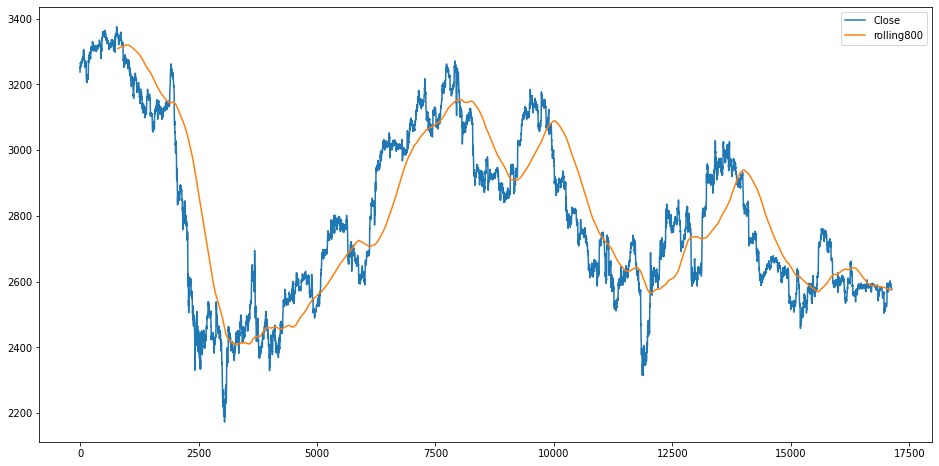

In [ ]:
df[['Close', 'rolling800']].plot(label='ETH-USD', figsize=(16,8))

In [ ]:
df = df.fillna(0)

Experimenting and laying out step by step the process to build a simply trading strategy based on technical indicators. Skip to see function with all of the below implemented and generalised.

In [ ]:
df['Difference_Roll800'] = df['Close'] - df['rolling800']

In [ ]:
df['Sell'] = (np.sign(df['Difference_Roll800']) == -1)

In [ ]:
df['Hold'] = (np.sign(df['Difference_Roll800']) == 1)

In [ ]:
df['Return_Roll800'] = df['pct_change1']
df.loc[df['Sell'] == True,'Return_Roll800'] = 0

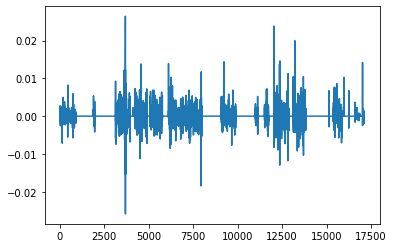

In [ ]:
df['Return_Roll800'].plot()

In [ ]:
df['AbsReturn_Roll800'] = df['Return_Roll800'].cumprod()

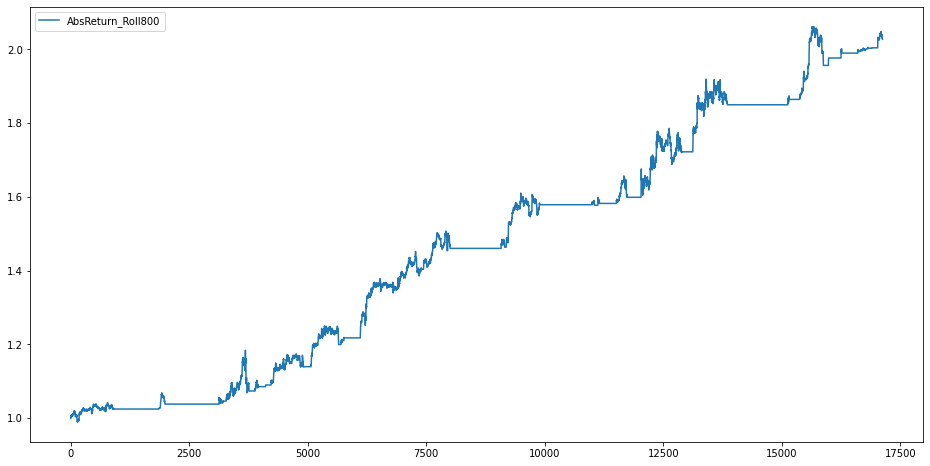

In [ ]:
df[['AbsReturn_Roll800']].plot(label='ETH-USD', figsize=(16,8))

In [85]:
df = df.drop(['Difference_Roll800', 'Sell', 'Hold', 'Return_Roll800'], axis = 1)

In [96]:
def GenerateTradeStrat(dataframe, num):

    dataframe['RollingAInd'] = dataframe['Mid'].rolling(num).mean()
    dataframe['RollingAInd'] = dataframe['RollingAInd'].fillna(0)
    dataframe['Difference'] = df['Close'] - df['RollingAInd']
    dataframe['Sell'] = (np.sign(dataframe['Difference']) == -1)
    dataframe['Hold'] = (np.sign(dataframe['Difference']) == 1)
    dataframe['Returns'] = dataframe['pct_change1']
    dataframe.loc[dataframe['Sell'] == True,'Returns'] = 0
    dataframe['Returns'] = dataframe['Returns'] + 1
    dataframe[f"{num}AbsReturns"] = dataframe['Returns'].cumprod()
    dataframe = dataframe.drop(['RollingAInd', 'Difference', 'Sell', 'Hold', 'Returns'], axis = 1)

    return dataframe

In [97]:
df = GenerateTradeStrat(df,1200)

In [98]:
df = GenerateTradeStrat(df,500)

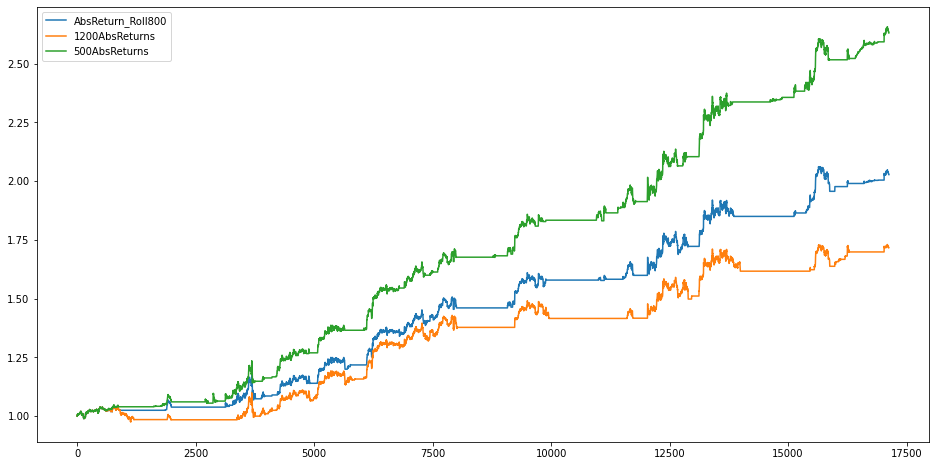

In [101]:
df[['AbsReturn_Roll800', '1200AbsReturns', '500AbsReturns']].plot(label='ETH-USD', figsize=(16,8))

Applying some of the ideas individually, we can obtain the cumulative time for certain thresholds or whatever to be reached. In the following, examine the data grouped by day but could just as easily be grouped by different investments or another characteristic.

In [ ]:
df = df.dropna(subset=['rolling10'])

In [ ]:
df_subset = df.groupby(['Day'])['rolling10'].idxmax()

In [ ]:
df_subset = df_subset.reset_index()
df_subset.columns = ['Day', 'MaxIndex']

In [ ]:
df_subset['MaxAmount'] = df_subset['MaxIndex'].apply(lambda x: df['rolling10'].loc[x])

And similarly for the minimum of each day...

In [ ]:
df_subset['MinIndex'] = df.groupby(['Day'])['rolling10'].idxmin().tolist()
df_subset['MinAmount'] = df_subset['MinIndex'].apply(lambda x: df['rolling10'].loc[x])

In [ ]:
df_subset['MidAmount'] = (df_subset['MinAmount'] + df_subset['MaxAmount']) / 2

The below uses this "MidAmount" pricing for each day, to then search the original dataframe, per day, for the index at which the rolling10 price is closest to the target "MidAmount". This can them be used to find the time between periods of low-mid-high.

In [ ]:
df_subset['MidIndex'] = df_subset[['Day', 'MidAmount']].apply(lambda x: abs(df.loc[(df['Day'] ==
                        x['Day']), 'rolling10'] - x['MidAmount']).idxmin(), axis=1).tolist()

In [ ]:
df_subset

,Day,MaxIndex,MaxAmount,MinIndex,MinAmount,MidAmount,MidIndex
0,2022-01-14,271,3324.922852,0,0.000000,1662.461426,146
1,2022-01-15,538,3360.405481,448,3286.612964,3323.509222,427
2,2022-01-16,781,3372.653809,716,3308.144116,3340.398962,751
3,2022-01-17,863,3355.307678,1133,3166.257275,3260.782477,1010
4,2022-01-18,1170,3230.619104,1377,3102.861572,3166.740338,1295
5,2022-01-19,1469,3167.993213,1543,3060.822473,3114.407843,1585
6,2022-01-20,1927,3252.527429,2014,3025.249646,3138.888538,1880
7,2022-01-21,2015,3020.537915,2297,2553.294934,2786.916425,2232
8,2022-01-22,2319,2602.644934,2544,2344.625061,2473.634998,2462
9,2022-01-23,2712,2533.413806,2836,2397.860156,2465.636981,2679


In [ ]:
import plotly.graph_objects as go

In [ ]:
df_subset.drop(index=df.index[0], axis=0, inplace=True)

In [ ]:
fig = go.Figure(data=
    [go.Candlestick(x=df.index,
                    open=df_subset["MidAmount"],
                    high=df_subset["MaxAmount"],
                    low=df_subset["MinAmount"],
                    close=df_subset["MidAmount"])]
)

fig.update_layout(
    title="Candlestick Chart of ETH-USD by Day",
    yaxis_title="USD"
)

fig.show()